# Predicting ADR Fluctuations with LSTM

In this example, the LSTM model is used to forecast ADR on the hotel cancellation datasets as provided by Antonio, Almeida and Nunes (2019). Attributions provided below.

#### Attributions

The below code uses the LSTM model from the TensorFlow library, of which the original authors **(Copyright 2019 The TensorFlow Authors)** have made available under the Apache 2.0 license. Modifications have been made where appropriate for conducting analysis on the dataset specific to this example.

The data used in this example is sourced from [Antonio, Almeida and Nunes (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191).

The below work and findings are not endorsed by the original authors in any way.

#### Apache 2.0 License

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Python version

In [1]:
from platform import python_version
print(python_version())

3.6.9


## Import Libraries

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
tf.random.set_seed(1234)

In [4]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

from math import sqrt
from numpy.random import seed
seed(1)
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM


dtypes = {
        'IsCanceled':                                    'float64',
        'LeadTime':                                          'float64',
        'StaysInWeekendNights':                                     'float64',
        'StaysInWeekNights':                                     'float64',
        'Adults':                            'float64',
        'Children':                            'float64',
        'Babies':                                  'float64',
        'Meal':                                    'category',
        'Country':                                               'category',
        'MarketSegment':                                    'category',
        'DistributionChannel':                                       'category',
        'IsRepeatedGuest':                               'float64',
        'PreviousCancellations':                                    'float64',
        'PreviousBookingsNotCanceled':                          'float64',
        'ReservedRoomType':                                             'category',
        'AssignedRoomType':                                            'category',
        'BookingChanges':                                                'float64',
        'DepositType':                                              'category',
        'Agent':                                              'category',
        'Company':                                 'category',
        'DaysInWaitingList':                                           'float64',
        'CustomerType':                                           'category',
        'ADR':                                          'float64',
        'RequiredCarParkingSpaces':                                      'float64',
        'TotalOfSpecialRequests':                                              'float64',
        'ReservationStatus':                                                'category'
        }

## Data Import and Manipulation

In [5]:
train_df = pd.read_csv("H2.csv", dtype=dtypes, converters={'ArrivalDateWeekNumber': '{:0>2}'.format})

In [6]:
a=train_df.head()
b=train_df
b
c=b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)
c=pd.DataFrame(c)
c
type(c)

pandas.core.frame.DataFrame

In [7]:
from pandas import DataFrame  

df = DataFrame(c, columns= ['ArrivalDateYear', 'ArrivalDateWeekNumber']) 
df

ArrivalDateYear ArrivalDateWeekNumber
0                 2015                    27
1                 2015                    27
2                 2015                    27
3                 2015                    27
4                 2015                    27
...                ...                   ...
79325             2017                    35
79326             2017                    35
79327             2017                    35
79328             2017                    35
79329             2017                    35

[79330 rows x 2 columns]

In [8]:
# https://datatofish.com/concatenate-values-python/

df1 = df['ArrivalDateYear'].map(str) + df['ArrivalDateWeekNumber'].map(str)
print (df1)
df1=pd.DataFrame(df1)

0        201527
1        201527
2        201527
3        201527
4        201527
          ...  
79325    201735
79326    201735
79327    201735
79328    201735
79329    201735
Length: 79330, dtype: object


In [9]:
df2 = DataFrame(c, columns= ['ADR']) 
df2

ADR
0        0.00
1       76.50
2       68.00
3       76.50
4       76.50
...       ...
79325   96.14
79326  225.43
79327  157.71
79328  104.40
79329  151.20

[79330 rows x 1 columns]

In [10]:
type(df1)

pandas.core.frame.DataFrame

In [11]:
df3=pd.concat([df1, df2], axis = 1)
df3
df3.columns = ['FullDate', 'ADR']

In [12]:
df3
df3.sort_values(['FullDate','ADR'], ascending=True)

FullDate     ADR
0       201527    0.00
11      201527   43.00
6       201527   58.67
29      201527   60.00
36141   201527   60.00
...        ...     ...
79084   201735  259.00
79305   201735  266.75
79010   201735  270.00
79091   201735  270.00
33605   201735  272.50

[79330 rows x 2 columns]

In [13]:
df4 = df3.groupby('FullDate').agg("mean")
df4
df4.sort_values(['FullDate'], ascending=True)

ADR
FullDate            
201527     78.165879
201528     70.247336
201529     73.996534
201530     66.766446
201531     65.363578
...              ...
201731    138.898408
201732    142.909221
201733    144.839923
201734    135.892708
201735    128.586952

[115 rows x 1 columns]

In [14]:
tseries=df4['ADR']
tseries

FullDate
201527     78.165879
201528     70.247336
201529     73.996534
201530     66.766446
201531     65.363578
             ...    
201731    138.898408
201732    142.909221
201733    144.839923
201734    135.892708
201735    128.586952
Name: ADR, Length: 115, dtype: float64

In [15]:
# https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html
res = sm.tsa.ARMA(tseries, (1,1)).fit(disp=-1)
sm.stats.acorr_ljungbox(res.resid, lags=[10])

/home/michael/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/michael/.local/lib/python3.6/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([5.4871118]), array([0.85635875]))

In [16]:
result = adfuller(tseries)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.509649
p-value: 0.528733
Critical Values:
	1%: -3.490
	5%: -2.888
	10%: -2.581


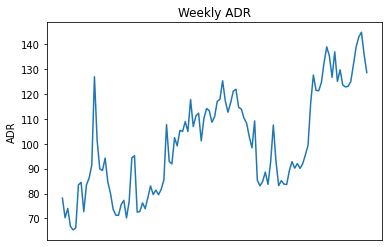

In [17]:
plt.plot(tseries)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('ADR')
plt.title("Weekly ADR")
plt.show()

In [18]:
df=pd.DataFrame(tseries)
df

ADR
FullDate            
201527     78.165879
201528     70.247336
201529     73.996534
201530     66.766446
201531     65.363578
...              ...
201731    138.898408
201732    142.909221
201733    144.839923
201734    135.892708
201735    128.586952

[115 rows x 1 columns]

In [19]:
df.to_csv("weekly adr h2.csv", sep='\t', encoding='utf-8')

In [20]:
df = df[:100]

In [21]:
df

ADR
FullDate            
201527     78.165879
201528     70.247336
201529     73.996534
201530     66.766446
201531     65.363578
...              ...
201716    121.461748
201717    121.316925
201718    124.661435
201719    132.639515
201720    138.961245

[100 rows x 1 columns]

In [22]:
df=np.array(df)

### Training and Validation data partition

In [23]:
train_size = int(len(df) * 0.8)
val_size = len(df) - train_size
train, val = df[0:train_size,:], df[train_size:len(df),:]

### Form dataset matrix

In [24]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
df

array([[ 78.16587912],
       [ 70.24733645],
       [ 73.99653409],
       [ 66.76644592],
       [ 65.36357759],
       [ 66.19251773],
       [ 83.49771567],
       [ 84.47268398],
       [ 72.68456522],
       [ 83.45116535],
       [ 86.20366422],
       [ 91.45293608],
       [126.92589397],
       [101.41107955],
       [ 89.9096928 ],
       [ 89.26574257],
       [ 94.24644567],
       [ 84.64276423],
       [ 80.10729242],
       [ 73.66123894],
       [ 71.29099688],
       [ 71.20313158],
       [ 75.51997732],
       [ 77.24792627],
       [ 70.17713287],
       [ 76.81377451],
       [ 94.30473002],
       [ 95.21253521],
       [ 72.52884422],
       [ 72.73885106],
       [ 76.22860526],
       [ 73.89953608],
       [ 78.31005495],
       [ 83.05294239],
       [ 79.5900545 ],
       [ 81.36655536],
       [ 79.51510608],
       [ 81.69887067],
       [ 85.45253049],
       [107.70945313],
       [ 92.86574132],
       [ 91.91686905],
       [102.45118665],
       [ 99

## Normalize dataset with MinMaxScaler

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
train

array([[0.20795679],
       [0.07933033],
       [0.14023118],
       [0.02278778],
       [0.        ],
       [0.01346506],
       [0.29456556],
       [0.31040265],
       [0.11891995],
       [0.29380941],
       [0.33852018],
       [0.4237878 ],
       [1.        ],
       [0.58554493],
       [0.39871981],
       [0.38825968],
       [0.46916474],
       [0.31316539],
       [0.23949253],
       [0.13478475],
       [0.09628324],
       [0.09485598],
       [0.16497754],
       [0.19304583],
       [0.07818996],
       [0.1859936 ],
       [0.47011149],
       [0.48485761],
       [0.11639047],
       [0.11980175],
       [0.17648829],
       [0.13865558],
       [0.21029874],
       [0.28734079],
       [0.23109067],
       [0.25994762],
       [0.22987323],
       [0.26534565],
       [0.32631899],
       [0.68785384],
       [0.44673699],
       [0.43132379],
       [0.60244012],
       [0.54894409],
       [0.64998361],
       [0.64319663],
       [0.70748455],
       [0.642

In [27]:
val = scaler.fit_transform(val)
val

array([[0.17175584],
       [0.        ],
       [0.03578306],
       [0.01032308],
       [0.00809862],
       [0.1079319 ],
       [0.17290013],
       [0.12595784],
       [0.15895961],
       [0.1235353 ],
       [0.15807057],
       [0.22151887],
       [0.29161135],
       [0.59890005],
       [0.79709186],
       [0.68629491],
       [0.68369873],
       [0.74365417],
       [0.88667337],
       [1.        ]])

## Configure LSTM model

In [28]:
# Lookback period
lookback = 5
X_train, Y_train = create_dataset(train, lookback)
X_val, Y_val = create_dataset(val, lookback)

In [29]:
X_train

array([[0.20795679, 0.07933033, 0.14023118, 0.02278778, 0.        ],
       [0.07933033, 0.14023118, 0.02278778, 0.        , 0.01346506],
       [0.14023118, 0.02278778, 0.        , 0.01346506, 0.29456556],
       [0.02278778, 0.        , 0.01346506, 0.29456556, 0.31040265],
       [0.        , 0.01346506, 0.29456556, 0.31040265, 0.11891995],
       [0.01346506, 0.29456556, 0.31040265, 0.11891995, 0.29380941],
       [0.29456556, 0.31040265, 0.11891995, 0.29380941, 0.33852018],
       [0.31040265, 0.11891995, 0.29380941, 0.33852018, 0.4237878 ],
       [0.11891995, 0.29380941, 0.33852018, 0.4237878 , 1.        ],
       [0.29380941, 0.33852018, 0.4237878 , 1.        , 0.58554493],
       [0.33852018, 0.4237878 , 1.        , 0.58554493, 0.39871981],
       [0.4237878 , 1.        , 0.58554493, 0.39871981, 0.38825968],
       [1.        , 0.58554493, 0.39871981, 0.38825968, 0.46916474],
       [0.58554493, 0.39871981, 0.38825968, 0.46916474, 0.31316539],
       [0.39871981, 0.38825968, 0.

In [30]:
Y_train

array([0.01346506, 0.29456556, 0.31040265, 0.11891995, 0.29380941,
       0.33852018, 0.4237878 , 1.        , 0.58554493, 0.39871981,
       0.38825968, 0.46916474, 0.31316539, 0.23949253, 0.13478475,
       0.09628324, 0.09485598, 0.16497754, 0.19304583, 0.07818996,
       0.1859936 , 0.47011149, 0.48485761, 0.11639047, 0.11980175,
       0.17648829, 0.13865558, 0.21029874, 0.28734079, 0.23109067,
       0.25994762, 0.22987323, 0.26534565, 0.32631899, 0.68785384,
       0.44673699, 0.43132379, 0.60244012, 0.54894409, 0.64998361,
       0.64319663, 0.70748455, 0.64285672, 0.85207922, 0.67514459,
       0.74433749, 0.76267414, 0.58138821, 0.72872326, 0.7930007 ,
       0.77851656, 0.70323679, 0.7393136 , 0.83980916, 0.85343631,
       0.9741984 , 0.8437535 , 0.76887505, 0.82939327, 0.90660036,
       0.9187816 , 0.80115282, 0.78953003, 0.73009895, 0.69643783,
       0.60814505, 0.5361015 , 0.71180524, 0.32517525, 0.28813093,
       0.31633414, 0.37780986, 0.29748547, 0.44533731])

Epoch 1/100
59/59 - 0s - loss: 0.1007 - val_loss: 0.0440
Epoch 2/100
59/59 - 0s - loss: 0.0426 - val_loss: 0.0197
Epoch 3/100
59/59 - 0s - loss: 0.0273 - val_loss: 0.0240
Epoch 4/100
59/59 - 0s - loss: 0.0254 - val_loss: 0.0246
Epoch 5/100
59/59 - 0s - loss: 0.0250 - val_loss: 0.0268
Epoch 6/100
59/59 - 0s - loss: 0.0247 - val_loss: 0.0266
Epoch 7/100
59/59 - 0s - loss: 0.0245 - val_loss: 0.0282
Epoch 8/100
59/59 - 0s - loss: 0.0244 - val_loss: 0.0240
Epoch 9/100
59/59 - 0s - loss: 0.0243 - val_loss: 0.0245
Epoch 10/100
59/59 - 0s - loss: 0.0240 - val_loss: 0.0240
Epoch 11/100
59/59 - 0s - loss: 0.0237 - val_loss: 0.0226
Epoch 12/100
59/59 - 0s - loss: 0.0236 - val_loss: 0.0260
Epoch 13/100
59/59 - 0s - loss: 0.0232 - val_loss: 0.0228
Epoch 14/100
59/59 - 0s - loss: 0.0231 - val_loss: 0.0241
Epoch 15/100
59/59 - 0s - loss: 0.0228 - val_loss: 0.0260
Epoch 16/100
59/59 - 0s - loss: 0.0226 - val_loss: 0.0229
Epoch 17/100
59/59 - 0s - loss: 0.0224 - val_loss: 0.0237
Epoch 18/100
59/59 - 0s

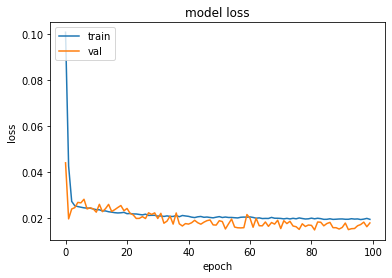

In [31]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, lookback)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=1, verbose=2)


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
# Generate predictions
trainpred = model.predict(X_train)
valpred = model.predict(X_val)

In [33]:
trainpred

array([[0.12416821],
       [0.12380154],
       [0.2820892 ],
       [0.2830265 ],
       [0.20114733],
       [0.3281207 ],
       [0.33519536],
       [0.41052502],
       [0.74590355],
       [0.53113246],
       [0.50470996],
       [0.45211887],
       [0.49490392],
       [0.36867377],
       [0.32106915],
       [0.22878836],
       [0.19413573],
       [0.18186717],
       [0.219803  ],
       [0.23393449],
       [0.17023587],
       [0.24432707],
       [0.40227905],
       [0.418746  ],
       [0.21418676],
       [0.23356068],
       [0.23484588],
       [0.20544691],
       [0.25573206],
       [0.298846  ],
       [0.27138767],
       [0.3025111 ],
       [0.2784343 ],
       [0.30651963],
       [0.34139407],
       [0.57117516],
       [0.4256855 ],
       [0.4834423 ],
       [0.57694244],
       [0.54786277],
       [0.6367354 ],
       [0.628424  ],
       [0.6992733 ],
       [0.656017  ],
       [0.80865175],
       [0.68737286],
       [0.77432364],
       [0.755

In [34]:
valpred

array([[0.12007082],
       [0.17587258],
       [0.20975536],
       [0.19162363],
       [0.22184932],
       [0.19630967],
       [0.22194058],
       [0.25662714],
       [0.3031967 ],
       [0.5003112 ],
       [0.62610483],
       [0.6292268 ],
       [0.6896128 ],
       [0.73959464]], dtype=float32)

In [35]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
valpred = scaler.inverse_transform(valpred)
Y_val = scaler.inverse_transform([Y_val])
predictions = valpred

In [36]:
Y_train.shape

(1, 74)

In [37]:
Y_val.shape

(1, 14)

In [38]:
X_train.shape

(74, 1, 5)

In [39]:
X_val.shape

(14, 1, 5)

In [40]:
Y_train

array([[ 83.92909653,  99.60980256, 100.49324761,  89.81171564,
         99.56762206, 102.06173543, 106.81824207, 138.96124481,
        115.84158413, 105.41986776, 104.83636712, 109.34951637,
        100.6473619 ,  96.53764872,  90.69670601,  88.54896583,
         88.46934871,  92.38095893,  93.94670002,  87.53966364,
         93.55330342, 109.40232939, 110.22491613,  89.67061265,
         89.86090551,  93.0230658 ,  90.91263347,  94.90912343,
         99.2067815 ,  96.0689655 ,  97.67870079,  96.00105272,
         97.97982065, 101.38111292, 121.5487101 , 108.09842297,
        107.23862423, 116.78405319, 113.7998699 , 119.43618489,
        119.05758489, 122.64377569, 119.03862377, 130.70973937,
        120.83974653, 124.69955307, 125.72243165, 115.60970908,
        123.82854048, 127.41414606, 126.60617371, 122.40682163,
        124.4193043 , 130.02527537, 130.78544243, 137.52194714,
        130.24530337, 126.06833859, 129.44424318, 133.75110723,
        134.43061673, 127.86889807, 127.

In [41]:
Y_val

array([[ 89.19876623,  92.82290682,  90.20431193,  92.04525896,
         90.06917483,  91.99566508,  95.53501946,  99.44500705,
        116.58657688, 127.64236479, 121.46174792, 121.31692451,
        124.66143536, 132.63951467]])

In [42]:
X_train

array([[[0.20795679, 0.07933033, 0.14023118, 0.02278778, 0.        ]],

       [[0.07933033, 0.14023118, 0.02278778, 0.        , 0.01346506]],

       [[0.14023118, 0.02278778, 0.        , 0.01346506, 0.29456556]],

       [[0.02278778, 0.        , 0.01346506, 0.29456556, 0.31040265]],

       [[0.        , 0.01346506, 0.29456556, 0.31040265, 0.11891995]],

       [[0.01346506, 0.29456556, 0.31040265, 0.11891995, 0.29380941]],

       [[0.29456556, 0.31040265, 0.11891995, 0.29380941, 0.33852018]],

       [[0.31040265, 0.11891995, 0.29380941, 0.33852018, 0.4237878 ]],

       [[0.11891995, 0.29380941, 0.33852018, 0.4237878 , 1.        ]],

       [[0.29380941, 0.33852018, 0.4237878 , 1.        , 0.58554493]],

       [[0.33852018, 0.4237878 , 1.        , 0.58554493, 0.39871981]],

       [[0.4237878 , 1.        , 0.58554493, 0.39871981, 0.38825968]],

       [[1.        , 0.58554493, 0.39871981, 0.38825968, 0.46916474]],

       [[0.58554493, 0.39871981, 0.38825968, 0.46916474, 0.31316

In [43]:
X_val

array([[[0.17175584, 0.        , 0.03578306, 0.01032308, 0.00809862]],

       [[0.        , 0.03578306, 0.01032308, 0.00809862, 0.1079319 ]],

       [[0.03578306, 0.01032308, 0.00809862, 0.1079319 , 0.17290013]],

       [[0.01032308, 0.00809862, 0.1079319 , 0.17290013, 0.12595784]],

       [[0.00809862, 0.1079319 , 0.17290013, 0.12595784, 0.15895961]],

       [[0.1079319 , 0.17290013, 0.12595784, 0.15895961, 0.1235353 ]],

       [[0.17290013, 0.12595784, 0.15895961, 0.1235353 , 0.15807057]],

       [[0.12595784, 0.15895961, 0.1235353 , 0.15807057, 0.22151887]],

       [[0.15895961, 0.1235353 , 0.15807057, 0.22151887, 0.29161135]],

       [[0.1235353 , 0.15807057, 0.22151887, 0.29161135, 0.59890005]],

       [[0.15807057, 0.22151887, 0.29161135, 0.59890005, 0.79709186]],

       [[0.22151887, 0.29161135, 0.59890005, 0.79709186, 0.68629491]],

       [[0.29161135, 0.59890005, 0.79709186, 0.68629491, 0.68369873]],

       [[0.59890005, 0.79709186, 0.68629491, 0.68369873, 0.74365

In [44]:
# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_val[0], valpred[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))

Train Score: 7.66 RMSE
Validation Score: 7.11 RMSE


In [45]:
# Train predictions
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[lookback:len(trainpred)+lookback, :] = trainpred

In [46]:
# Validation predictions
valpredPlot = np.empty_like(df)
valpredPlot[:, :] = np.nan
valpredPlot[len(trainpred)+(lookback*2)+1:len(df)-1, :] = valpred

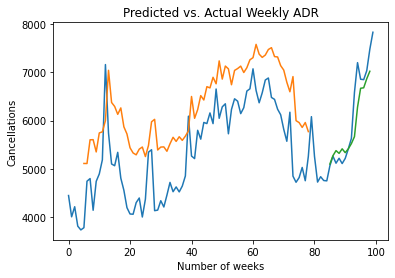

In [47]:
# Plot all predictions
inversetransform, =plt.plot(scaler.inverse_transform(df))
trainpred, =plt.plot(scaler.inverse_transform(trainpredPlot))
valpred, =plt.plot(scaler.inverse_transform(valpredPlot))
plt.xlabel('Number of weeks')
plt.ylabel('Cancellations')
plt.title("Predicted vs. Actual Weekly ADR")
plt.show()

In [48]:
Y_val=Y_val.reshape(-1)
Y_val.shape
Y_val=pd.Series(Y_val)

In [49]:
Y_val

0      89.198766
1      92.822907
2      90.204312
3      92.045259
4      90.069175
5      91.995665
6      95.535019
7      99.445007
8     116.586577
9     127.642365
10    121.461748
11    121.316925
12    124.661435
13    132.639515
dtype: float64

In [50]:
np.mean(Y_val)

106.11604817801246

In [51]:
predictions=predictions.reshape(-1)
predictions.shape
predictions=pd.Series(predictions)

In [52]:
predictions

0      89.875916
1      92.988716
2      94.878815
3      93.867371
4      95.553452
5      94.128769
6      95.558548
7      97.493477
8     100.091270
9     111.086967
10    118.104156
11    118.278305
12    121.646828
13    124.434975
dtype: float32

In [53]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [54]:
mda(Y_val, predictions)

0.8571428571428571

In [55]:
# https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/

mse = mean_squared_error(Y_val, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 7.107234


In [56]:
forecast_error = (predictions-Y_val)
forecast_error

0      0.677149
1      0.165809
2      4.674503
3      1.822112
4      5.484277
5      2.133104
6      0.023529
7     -1.951530
8    -16.495306
9    -16.555397
10    -3.357591
11    -3.038619
12    -3.014608
13    -8.204540
dtype: float64

In [57]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

-2.6883650289471723

In [58]:
X_train

array([[[0.20795679, 0.07933033, 0.14023118, 0.02278778, 0.        ]],

       [[0.07933033, 0.14023118, 0.02278778, 0.        , 0.01346506]],

       [[0.14023118, 0.02278778, 0.        , 0.01346506, 0.29456556]],

       [[0.02278778, 0.        , 0.01346506, 0.29456556, 0.31040265]],

       [[0.        , 0.01346506, 0.29456556, 0.31040265, 0.11891995]],

       [[0.01346506, 0.29456556, 0.31040265, 0.11891995, 0.29380941]],

       [[0.29456556, 0.31040265, 0.11891995, 0.29380941, 0.33852018]],

       [[0.31040265, 0.11891995, 0.29380941, 0.33852018, 0.4237878 ]],

       [[0.11891995, 0.29380941, 0.33852018, 0.4237878 , 1.        ]],

       [[0.29380941, 0.33852018, 0.4237878 , 1.        , 0.58554493]],

       [[0.33852018, 0.4237878 , 1.        , 0.58554493, 0.39871981]],

       [[0.4237878 , 1.        , 0.58554493, 0.39871981, 0.38825968]],

       [[1.        , 0.58554493, 0.39871981, 0.38825968, 0.46916474]],

       [[0.58554493, 0.39871981, 0.38825968, 0.46916474, 0.31316

In [59]:
X_train.shape

(74, 1, 5)

## Validate Predictions on Test Data

In [60]:
Xnew = np.array([tseries.iloc[95:100],tseries.iloc[96:101],tseries.iloc[97:102],tseries.iloc[98:103],tseries.iloc[99:104],tseries.iloc[100:105],tseries.iloc[101:106],tseries.iloc[102:107],tseries.iloc[103:108],tseries.iloc[104:109],tseries.iloc[105:110],tseries.iloc[106:111],tseries.iloc[107:112],tseries.iloc[108:113],tseries.iloc[109:114]])

In [61]:
Xnew

array([[121.46174792, 121.31692451, 124.66143536, 132.63951467,
        138.96124481],
       [121.31692451, 124.66143536, 132.63951467, 138.96124481,
        135.29018595],
       [124.66143536, 132.63951467, 138.96124481, 135.29018595,
        126.70549121],
       [132.63951467, 138.96124481, 135.29018595, 126.70549121,
        136.96731501],
       [138.96124481, 135.29018595, 126.70549121, 136.96731501,
        125.04368653],
       [135.29018595, 126.70549121, 136.96731501, 125.04368653,
        129.75435252],
       [126.70549121, 136.96731501, 125.04368653, 129.75435252,
        123.69777658],
       [136.96731501, 125.04368653, 129.75435252, 123.69777658,
        122.84483755],
       [125.04368653, 129.75435252, 123.69777658, 122.84483755,
        123.08675055],
       [129.75435252, 123.69777658, 122.84483755, 123.08675055,
        124.98114286],
       [123.69777658, 122.84483755, 123.08675055, 124.98114286,
        131.79458537],
       [122.84483755, 123.08675055, 124.981

In [62]:
Xnew = scaler.fit_transform(Xnew)
Xnew
Xnewformat = np.reshape(Xnew, (Xnew.shape[0], 1, Xnew.shape[1]))
ynew=model.predict(Xnewformat)

In [63]:
Xnew.shape

(15, 5)

In [64]:
ynew

array([[0.52564657],
       [0.5079376 ],
       [0.29498988],
       [0.6378594 ],
       [0.20808631],
       [0.41548872],
       [0.1438112 ],
       [0.13431844],
       [0.12266748],
       [0.1664215 ],
       [0.34982425],
       [0.5403698 ],
       [0.714114  ],
       [0.8724112 ],
       [0.6944164 ]], dtype=float32)

In [65]:
type(ynew)

numpy.ndarray

In [66]:
ynew.shape

(15, 1)

In [67]:
actual = tseries.iloc[100:115]
actual

FullDate
201721    135.290186
201722    126.705491
201723    136.967315
201724    125.043687
201725    129.754353
201726    123.697777
201727    122.844838
201728    123.086751
201729    124.981143
201730    131.794585
201731    138.898408
201732    142.909221
201733    144.839923
201734    135.892708
201735    128.586952
Name: ADR, dtype: float64

In [68]:
actual = np.array(actual)
actual

array([135.29018595, 126.70549121, 136.96731501, 125.04368653,
       129.75435252, 123.69777658, 122.84483755, 123.08675055,
       124.98114286, 131.79458537, 138.89840845, 142.90922096,
       144.83992318, 135.89270833, 128.58695175])

In [69]:
actual=actual.reshape(15,-1)
actual.shape

(15, 1)

In [70]:
actual

array([[135.29018595],
       [126.70549121],
       [136.96731501],
       [125.04368653],
       [129.75435252],
       [123.69777658],
       [122.84483755],
       [123.08675055],
       [124.98114286],
       [131.79458537],
       [138.89840845],
       [142.90922096],
       [144.83992318],
       [135.89270833],
       [128.58695175]])

In [71]:
ynew=ynew.reshape(-1)
actual=actual.reshape(-1)
actualpd=pd.Series(actual)

In [72]:
np.min(df)

65.36357758620683

In [73]:
ynew

array([0.52564657, 0.5079376 , 0.29498988, 0.6378594 , 0.20808631,
       0.41548872, 0.1438112 , 0.13431844, 0.12266748, 0.1664215 ,
       0.34982425, 0.5403698 , 0.714114  , 0.8724112 , 0.6944164 ],
      dtype=float32)

In [74]:
maxt=np.max(tseries)

In [75]:
mint=np.min(tseries)

In [76]:
ynew = ynew * np.abs(maxt-mint) + np.min(tseries)
ynewpd=pd.Series(ynew)

In [77]:
actualpd

0     135.290186
1     126.705491
2     136.967315
3     125.043687
4     129.754353
5     123.697777
6     122.844838
7     123.086751
8     124.981143
9     131.794585
10    138.898408
11    142.909221
12    144.839923
13    135.892708
14    128.586952
dtype: float64

In [78]:
ynewpd

0     107.140045
1     105.732605
2      88.808296
3     116.058319
4      81.901520
5      98.385101
6      76.793167
7      76.038719
8      75.112740
9      78.590149
10     93.166336
11    108.310196
12    122.118752
13    134.699646
14    120.553261
dtype: float32

In [79]:
mda(actualpd, ynewpd)

0.8666666666666667

In [80]:
mse = mean_squared_error(actualpd, ynewpd)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 36.592822


In [81]:
forecast_error = (ynewpd-actualpd)
forecast_error

0    -28.150141
1    -20.972886
2    -48.159019
3     -8.985367
4    -47.852833
5    -25.312675
6    -46.051670
7    -47.048031
8    -49.868403
9    -53.204436
10   -45.732072
11   -34.599025
12   -22.721172
13    -1.193062
14    -8.033691
dtype: float64

In [82]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

-32.525632345071955

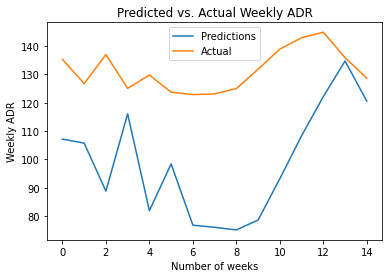

In [83]:
predictons, =plt.plot(ynewpd, label='Predictions')
actual, =plt.plot(actualpd, label='Actual')
plt.xlabel('Number of weeks')
plt.ylabel('Weekly ADR')
plt.title("Predicted vs. Actual Weekly ADR")
plt.legend(loc = 'upper center')
plt.show()

In [84]:
np.mean(actualpd)

131.41955578664096